In [ ]:
# https://unit8co.github.io/darts/examples/18-TiDE-examples.html#

In [1]:
pip install darts

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install --upgrade darts[all]


Note: you may need to restart the kernel to use updated packages.


In [5]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import pickle
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts import TimeSeries
from darts.dataprocessing.transformers.scaler import Scaler
from darts.datasets import AusBeerDataset
from darts.metrics import mae, mse
from darts.models import NHiTSModel, TiDEModel


Récupération des données

In [8]:
# Récupération du fichier de données
with open("magnific7_1day.pkl", "rb") as f:
    data_dict = pickle.load(f)

In [10]:
# Le fichier pickle est un dictionnaire avec en clés le nom des sociétés et en valeur des dataframe
print(data_dict.keys())


dict_keys(['APPLE', 'MICROSOFT', 'AMAZON', 'ALPHABET', 'NVIDIA', 'META', 'TESLA'])


In [12]:
series_list = []

for company, df in data_dict.items():
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["close"])
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    ts = TimeSeries.from_dataframe(df, value_cols="close", freq="B")
    series_list.append(ts)

In [14]:
train_series = []
val_series = []
test_series = []

for ts in series_list:
    n = len(ts)
    train_series.append(ts[:int(n*0.6)])
    val_series.append(ts[int(n*0.6):int(n*0.8)])
    test_series.append(ts[int(n*0.8):])


<Axes: xlabel='date'>

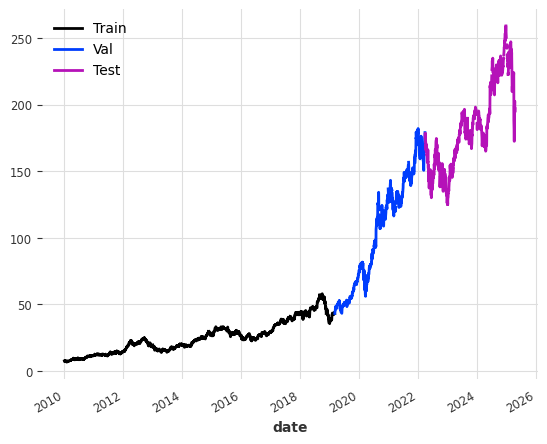

In [16]:
# Visualisation des données APPLE
train_series[0].plot(label="Train")
val_series[0].plot(label="Val")
test_series[0].plot(label="Test")


In [18]:
scaler = Scaler()
scaled_train_series = scaler.fit_transform(train_series)
scaled_val_series = scaler.transform(val_series)
scaled_test_series = scaler.transform(test_series)

Configuration des paramètres des modèles

In [21]:
optimizer_kwargs = {
    "lr": 1e-4,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 300,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    "input_chunk_length": 30,  # lookback window
    "output_chunk_length": 5,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    "likelihood": None,  # use a likelihood for probabilistic forecasts
    "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

Configuration des modèles

In [24]:
# Création du modèle NHiTS
model_nhits = NHiTSModel(**common_model_args, model_name="hi")
# Création du modèle TiDE
model_tide = TiDEModel(
    **common_model_args, use_reversible_instance_norm=False, model_name="tide0"
)
# Création du modèle TiDE avec RIN                                                        # Reversible Instance Normalization : on normalise chaque série temporelle individuellement
model_tide_rin = TiDEModel(
    **common_model_args, use_reversible_instance_norm=True, model_name="tide1"
)

models = {
    "NHiTS": model_nhits,
    "TiDE": model_tide,
    "TiDE+RIN": model_tide_rin,
}

Entraînement des modèles

In [26]:
for name, model in models.items():
    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    model.fit(
        series=scaled_train_series,
        val_series=scaled_val_series,
        verbose=False,
    )

    # Récupération du meilleur modèle
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=300` reached.


In [30]:
scaled_test_series

[<TimeSeries (DataArray) (date: 799, component: 1, sample: 1)>
 array([[[3.34069586]],
 
        [[3.27892885]],
 
        [[3.27306489]],
 
        [[3.35379203]],
 
        [[3.28772478]],
 
        [[3.22458952]],
 
        [[3.23064894]],
 
        [[3.19057858]],
 
        [[3.10574668]],
 
        [[3.14308053]],
 
 ...
 
        [[3.23612197]],
 
        [[3.75273651]],
 
        [[3.58795934]],
 
        [[3.73905395]],
 
        [[3.82447224]],
 
        [[3.81704457]],
 
        [[3.66321345]],
 
        [[3.71618452]],
 
        [[       nan]],
 
        [[3.64151681]]])
 Coordinates:
   * date       (date) datetime64[ns] 2022-03-30 2022-03-31 ... 2025-04-21
   * component  (component) <U5 'close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None
     metadata:           None,
 <TimeSeries (DataArray) (date: 799, component: 1, sample: 1)>
 array([[[3.14092873]],
 
        [[3.08099352]],
 
        [[3.09298056]],

In [32]:
# Suppression des NaN
scaled_test_series = [
    TimeSeries.from_series(
        pd.Series(ts.values().flatten(), index=ts.time_index).ffill()
    )
    for ts in scaled_test_series
]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=7) used to fit Scaler. This can result in a mismatch between the series and the underlying transformers.
C:\Users\peggy\anaconda3\Lib\site-packages\darts\metrics\metrics.py:993: RuntimeWarning: Mean of empty slice
  return np.nanmean(
C:\Users\peggy\anaconda3\Lib\site-packages\darts\metrics\metrics.py:374: RuntimeWarning: Mean of empty slice
  vals = component_reduction(vals, axis=COMP_AX)
C:\Users\peggy\anaconda3\Lib\site-packages\darts\metrics\metrics.py:1406: RuntimeWarning: Mean of empty slice
  return np.nanmean(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Only 1 TimeSeries (lists) were provided which is lower than the number of series (n=7) used to fit Scaler. This can result in a mismatch between the series and the underl

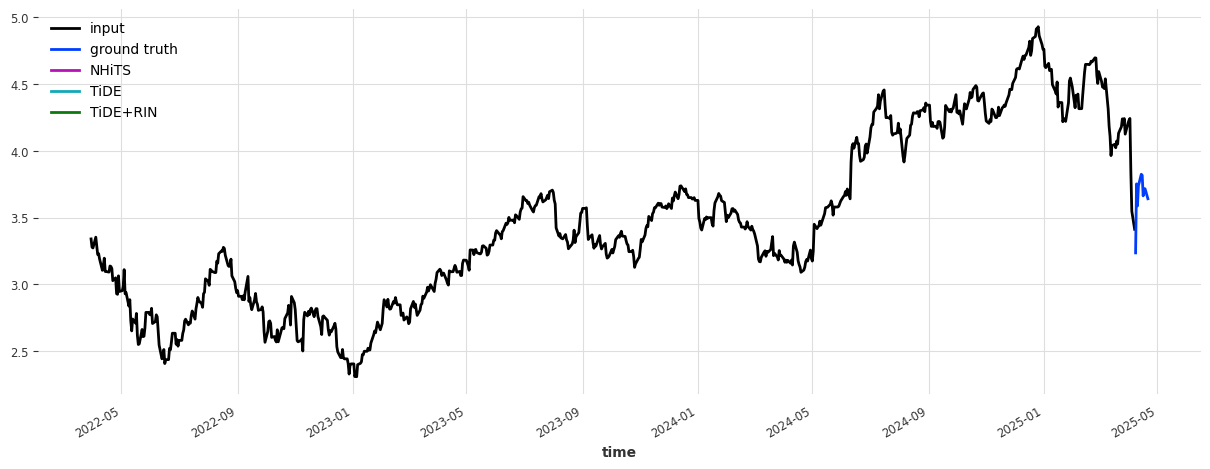

In [65]:
# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = common_model_args["output_chunk_length"] * 2
pred_input = scaled_test_series[0][:-pred_steps]

fig, ax = plt.subplots(figsize=(15, 5))
pred_input.plot(label="input")
scaled_test_series[0][-pred_steps:].plot(label="ground truth", ax=ax)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    pred_series = model.historical_forecasts(
        series=scaled_test_series[0],
        # start=len(scaled_test_series[0]) - pred_steps,
        # forecast_horizon=pred_steps,
        stride=1,
        retrain=False,
        # verbose=True,
    )
    pred_series1 = scaler.inverse_transform(pred_series)
    pred_series1.plot(label=model_name, ax=ax)

    result_accumulator[model_name] = {
        "mae": mae(scaled_test_series[0], pred_series1),
        "mse": mse(scaled_test_series[0], pred_series1),
    }

In [58]:
pred_series

[<TimeSeries (DataArray) (time: 769, component: 1, sample: 1)>
 array([[[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
 ...
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]],
 
        [[nan]]])
 Coordinates:
   * time       (time) datetime64[ns] 2022-05-11 2022-05-12 ... 2025-04-21
   * component  (component) object '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None
     metadata:           None]

In [36]:
model_name

'TiDE+RIN'

In [38]:
models.items

<function dict.items>

In [40]:
scaled_test_series[0]

<TimeSeries (DataArray) (date: 799, component: 1, sample: 1)>
array([[[3.34069586]],

       [[3.27892885]],

       [[3.27306489]],

       [[3.35379203]],

       [[3.28772478]],

       [[3.22458952]],

       [[3.23064894]],

       [[3.19057858]],

       [[3.10574668]],

       [[3.14308053]],

...

       [[3.23612197]],

       [[3.75273651]],

       [[3.58795934]],

       [[3.73905395]],

       [[3.82447224]],

       [[3.81704457]],

       [[3.66321345]],

       [[3.71618452]],

       [[3.71618452]],

       [[3.64151681]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-03-30 2022-03-31 ... 2025-04-21
  * component  (component) <U1 '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [43]:
pred_input

<TimeSeries (DataArray) (date: 789, component: 1, sample: 1)>
array([[[3.34069586]],

       [[3.27892885]],

       [[3.27306489]],

       [[3.35379203]],

       [[3.28772478]],

       [[3.22458952]],

       [[3.23064894]],

       [[3.19057858]],

       [[3.10574668]],

       [[3.14308053]],

...

       [[4.23944488]],

       [[4.1960516 ]],

       [[4.24139953]],

       [[4.12509773]],

       [[4.20777952]],

       [[4.22849883]],

       [[4.24218139]],

       [[3.83756841]],

       [[3.54808444]],

       [[3.41282252]]])
Coordinates:
  * date       (date) datetime64[ns] 2022-03-30 2022-03-31 ... 2025-04-07
  * component  (component) <U1 '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [45]:
pred_steps

10

In [47]:
pred_series


<TimeSeries (DataArray) (time: 769, component: 1, sample: 1)>
array([[[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

...

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]],

       [[nan]]])
Coordinates:
  * time       (time) datetime64[ns] 2022-05-11 2022-05-12 ... 2025-04-21
  * component  (component) object '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None
    metadata:           None

In [49]:
result_accumulator

{'NHiTS': {'mae': nan, 'mse': nan},
 'TiDE': {'mae': nan, 'mse': nan},
 'TiDE+RIN': {'mae': nan, 'mse': nan}}

<Axes: >

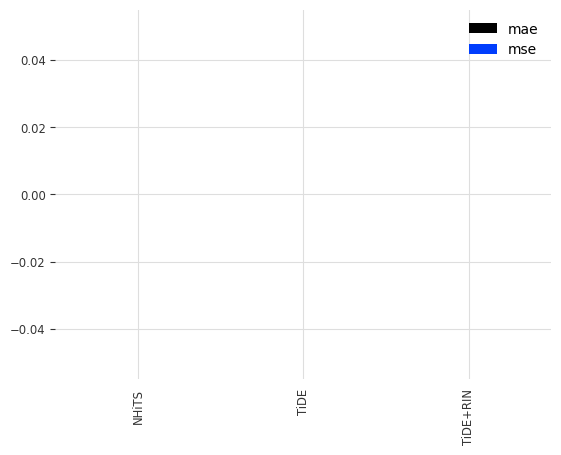

In [51]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.plot.bar()